# Aufgabe-F-FilmDialoge

## Allgemeines

Eine allgemeine Beschreibung der Laboraufgaben inklusive des Vorgehens, den Bewertungsrichtlinien und der Abgabe finden Sie  <a href="ML-allgemein.ipynb">hier</a>

## Datenquelle


* Laden Sie ihre Daten von http://141.72.190.207/ml_lab/F_dialoge herunter
    * Die Daten sind geschützt. 
        * Sie müssen evtl. in einem Netzwerk der DHBW (z.B. WLAN, VPN, ...) angemeldet sein. 
        * Sie können sich auf der Webseite mit dem Benutzernamen dhbw und dem Zugangsnamen "ml_LaB_4$" anmelden. 
* Die Daten sind in einem anwendungsspezifischen Format gespeichert.
    * Sie finden evtl. Informationen über die Daten in einer "README" Datei. 
    * Finden Sie keine solche Datei sind die Daten selbst erklärend. 
    
    



## Aufgabe

Die Daten-Sammlung 
* besteht aus Dialogen aus verschiedensten Filmen
* ist in der Readme Datei beschrieben

Erstellen Sie aus den einen Chatbot, der auf eine Frage mit einer Antwort im "Filmjargon" antwortet! 
* Verwenden Sie tiefe Neuronale Netze zu Erstellen des Chatbots! 
* Passen Sie den Chatbot so an, dass er für unterschiedliche Film-Genres unterschiedlich antwortet! 


# Lösung

Die Lösung der Aufgabe besteht aus mehreren Teilschritten, welche im Folgenden kurz genannt werden:

* Daten einlesen
* Daten vorverarbeiten
* Model erstellen
* Model trainieren
* Model abspeichern
* Model ausführen


# Abhängigkeiten des Projekts

* Tensorflow 2.8.2

In [12]:
import tensorflow as tf
import random 
import re #re = regular expressions
import os
import numpy as np 
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Eigene Abhängigkeiten des Projekts

* 

In [13]:
import src.data_helper as dh

## Konstanten

In [14]:
num_examples = 30000
test_size = 0.2

# Daten einlesen

Hier werden zuerst die rohen Daten eingelesen und innerhalb der Hilfsfunktion "readDataToLines" mit des "newline" Zeichen getrennt. Die Daten werden zwei Listen gespeichert, welche dann zurückgegeben werden.
Verwendet wurden folgende Funktionen:

* "open" um die Datei zu öffnen
* "read" um die Datei zu lesen
* "split" um die Daten anhand des "newline" Zeichen zu trennen und in einer Liste zu speichern

In [15]:
# read the data from the files
movie_lines, movie_conversations = dh.readDataToLines("data/unzipped/movie_lines.txt", "data/unzipped/movie_conversations.txt")

# Daten vorverarbeiten

In [16]:
# extract and mix conversations to a list
conversations_list = dh.readConversationsToList(movie_conversations)
random.shuffle(conversations_list)

# create a dictionary that maps each line id to the corresponding line
id2line = dh.readLinesToDict(movie_lines)

# remove all unnecessary characters from the lines and replace short forms with the full words
id2line = dh.cleanLines(id2line)

# split the conversations into requests and responses, each answer is used as a request for the next answer
requests, responses = dh.splitConversationsToRequestAndResponse(conversations_list, id2line)

print(f"Länge Fragen: {len(requests)}")
print(f"Länge Antworten: {len(responses)}")

# delete temporary variables
del(movie_lines, movie_conversations, conversations_list, id2line)

Länge Fragen: 221616
Länge Antworten: 221616


### Parameter wählen

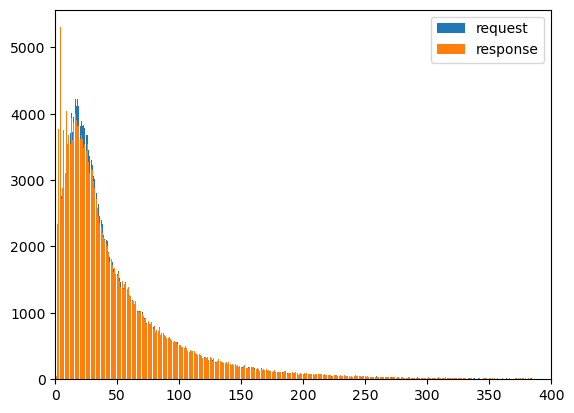

In [17]:
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# get the length of each line of the requests and save the occurrences in a dictionary
lengths_request = {}
for sentence in requests:
    length = len(sentence)
    if length in lengths_request:
        lengths_request[length] += 1
    else:
        lengths_request[length] = 1

# get the length of each line of the responses and save the occurrences in a dictionary
lengths_response = {}
for sentence in responses:
    length = len(sentence)
    if length in lengths_response:
        lengths_response[length] += 1
    else:
        lengths_response[length] = 1

# plot the occurrences of the lengths of the requests and responses in the same plot while only showind x values up to 200
plt.bar(lengths_request.keys(), lengths_request.values(), label="request")
plt.bar(lengths_response.keys(), lengths_response.values(), label="response")
plt.xlim(0, 400)
plt.legend()
plt.show()

In [18]:
# based on the result set the parameters
max_wordcount_in_sentence = 30

# delete requests/responses with length > max_wordcount_in_sentence
requests, responses = dh.removeLongSequences(requests, responses, 1, max_wordcount_in_sentence)

print(f"Länge Fragen: {len(requests)}")
print(f"Länge Antworten: {len(responses)}")


Länge Fragen: 196695
Länge Antworten: 196695


In [19]:
# limit the size of the dataset
requests = requests[:num_examples]
responses = responses[:num_examples]

# encapsule the requests and responses with the tokens <S> (Start) and <E> (End)
requests = dh.encapsuleWithTokens(requests, '<S>', '<E>')
responses = dh.encapsuleWithTokens(responses, '<S>', '<E>')#todo muss das so?


# get a dictionary of all unique words with their frequency
word2count = dh.getWord2Count(requests, responses)

# filter out words with a frequency of 5 or less
min_wordFrequency = 20
word2count = {k:v for k,v in word2count.items() if v > min_wordFrequency}

Wie man in der obigen Grafik erkennt, sind ab einer Sequenzlänge von 200 nur noch wenige Daten vorhanden. Da die Sequenzlänge maßgeblich auch für den Speicherbedarf in weiteren Schritten ist, wird diese hier auf 200 begrenzt.

In [20]:
oov_token = '<UNK>'
maxlen = len(word2count) + 1
del(word2count)


tokenizer = Tokenizer(num_words=maxlen, oov_token=oov_token, filters='', lower=False)
tokenizer.fit_on_texts(requests)
tokenizer.fit_on_texts(responses)

word2index = tokenizer.word_index
index2word ={k:v for v,k in word2index.items()}
print('Größe des Wörterbuchs: ',len(word2index))

np.save(arr=word2index, file="data/word2index.dict")
np.save(arr=index2word, file="data/index2word.dict")

Größe des Wörterbuchs:  19885


In [21]:
input_tensor = tokenizer.texts_to_sequences(requests)
target_tensor = tokenizer.texts_to_sequences(responses)

max_sen_length = dh.get_maximum_sentence_length(input_tensor, target_tensor)


pad_type = 'post'
trunc_type = 'post'

input_tensor = pad_sequences(input_tensor, padding=pad_type, truncating=trunc_type, maxlen=max_sen_length)
target_tensor = pad_sequences(target_tensor, padding=pad_type, truncating=trunc_type, maxlen=max_sen_length)


In [22]:
input_encoder_train, input_encoder_val, input_decoder_train, input_decoder_val = train_test_split(input_tensor, target_tensor, test_size=test_size)

# Decoder Output erstellen
output_decoder_train = [i[1:] for i in input_decoder_train]
output_decoder_val = [i[1:] for i in input_decoder_val]

#Dimension erhöhen
output_decoder_train = pad_sequences(output_decoder_train, padding=pad_type, truncating=trunc_type, maxlen=max_sen_length)
output_decoder_val = pad_sequences(output_decoder_val, padding=pad_type, truncating=trunc_type, maxlen=max_sen_length)

# convert the decoder input to a one-hot encoded vector which the model can use
output_decoder_train = tf.keras.utils.to_categorical(output_decoder_train, num_classes=len(word2index), dtype="float32") # using float32 even though it's memory intensive because later steps need it to be float32
output_decoder_val = tf.keras.utils.to_categorical(output_decoder_val, num_classes=len(word2index), dtype="float32")

# Model erstellen

## Hyperparameter

In [23]:
outputDimension = 50 
lstm_units = 256
max_sentence_length = max_sen_length

## Encoder
- Input
- Embedding
- LSTM

In [24]:
# input tensor for the encoder, shape of each vector is determined by max_length which was also used to pad the data
inputEncoderTensor = tf.keras.Input(shape=(max_sentence_length, ), name = "inputEncoderTensor")

# embedding layer of the encoder, the input is the input tensor, the output is the embedding tensor
encoderEmbedding = tf.keras.layers.Embedding(len(word2index) + 1, output_dim = outputDimension, input_length = max_sentence_length, trainable = True, name = "embeddingEncoderLayer")(inputEncoderTensor)

# LSTM layer of the encoder, the input is the embedding tensor, the output is the output tensor and the hidden state of the encoder
encoderLSTM, encoderHiddenState, encoderCellState = tf.keras.layers.LSTM(units = lstm_units, return_sequences = True, return_state = True, name = "lstmEncoderLayer")(encoderEmbedding)

## Decoder
- Input
- Embedding
- LSTM
- Dense

In [25]:
# input tensor for the decoder, shape of each vector is determined by max_length which was also used to pad the data
inputDecoderTensor = tf.keras.Input(shape=(max_sentence_length, ), name="inputDecoderTensor")

# embedding layer of the decoder, the input is the input tensor, the output is the embedding tensor
decoderEmbedding = tf.keras.layers.Embedding(len(word2index) + 1, output_dim = outputDimension, input_length = max_sentence_length, trainable = True, name = "embeddingDecoderLayer")(inputDecoderTensor)

# LSTM layer of the decoder, the input is the embedding tensor and the state of the previous lstm layer, the output is the output tensor and the hidden state of the decoder
decoderLSTM, decoderHiddenState, decoderCellState = tf.keras.layers.LSTM(units = lstm_units, return_sequences = True, return_state = True, name = "lstmDecoderLayer")(decoderEmbedding, initial_state = [encoderHiddenState, encoderCellState])

# dense layer of the decoder, the input is the output tensor of the lstm layer, the output is the output tensor of the dense layer
# the dense layer has the same number of units as the number of words in the dictionary because the output of the dense layer is a vector with a probability for each word in the dictionary
decoderDense = tf.keras.layers.Dense(units = len(word2index), activation = "softmax", name = "denseLayer")(decoderLSTM)

## Summary

In [26]:
# Define the model 
model = tf.keras.models.Model([inputEncoderTensor, inputDecoderTensor], decoderDense)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputEncoderTensor (InputLayer  [(None, 32)]        0           []                               
 )                                                                                                
                                                                                                  
 inputDecoderTensor (InputLayer  [(None, 32)]        0           []                               
 )                                                                                                
                                                                                                  
 embeddingEncoderLayer (Embeddi  (None, 32, 50)      994300      ['inputEncoderTensor[0][0]']     
 ng)                                                                                          

# Trainieren des Models

In [27]:
# generate an early stopping callback to stop training when the validation loss stops improving so that the model doesn't overfit
# waits 3 epochs before stopping
# use val_loss as the metric because categorical_crossentropy calculates the difference between the predicted and actual values and by monitoring wether or not the loss would be decreasing or increasing we can see if the model is improving or not
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Train the model on the training data and evaluate it on the validation data
model.fit(x=[input_encoder_train, input_decoder_train],y=output_decoder_train , epochs=10, batch_size=32, callbacks=[earlyStopping])

Epoch 1/10
750/750 [==============================] - 398s 523ms/step - loss: 1.7780
Epoch 2/10
750/750 [==============================] - 401s 534ms/step - loss: 1.4004
Epoch 3/10
750/750 [==============================] - 397s 529ms/step - loss: 1.3209
Epoch 4/10
750/750 [==============================] - 393s 524ms/step - loss: 1.2767
Epoch 5/10
750/750 [==============================] - 393s 525ms/step - loss: 1.2497
Epoch 6/10
750/750 [==============================] - 416s 554ms/step - loss: 1.2282
Epoch 7/10
750/750 [==============================] - 403s 537ms/step - loss: 1.2108
Epoch 8/10
750/750 [==============================] - 398s 530ms/step - loss: 1.1955
Epoch 9/10
750/750 [==============================] - 398s 531ms/step - loss: 1.1817
Epoch 10/10
750/750 [==============================] - 401s 535ms/step - loss: 1.1687


In [28]:
# Evaluate the model on the validation set and store the results

loss = model.evaluate([input_encoder_val, input_decoder_val], output_decoder_val)
print('Test loss:', loss)

188/188 [==============================] - 61s 309ms/step - loss: 1.2269
Test loss: 1.2268613576889038


# Model abspeichern

In [29]:
# Modell speichern
dh.save_model(model, 'chatbot.h5')

# Gewichte speichern
for layer in model.layers:
    weights = layer.get_weights()
    if weights != []:
        np.savez(f'models/{layer.name}.npz', weights, dtype=object)

c:\Users\noah\anaconda3\envs\tensorflow_ml_stuff\lib\site-packages\numpy\lib\npyio.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


In [30]:
# Laden der beiden Vokabulare
index2word = np.load('./data/index2word.dict.npy',allow_pickle='TRUE').item()
word2index = np.load('./data/word2index.dict.npy',allow_pickle='TRUE').item()

print(index2word)

{1: '<UNK>', 2: '<S>', 3: '<E>', 4: 'you', 5: 'i', 6: 'is', 7: 'the', 8: 'to', 9: 'it', 10: 'a', 11: 'that', 12: 'what', 13: 'are', 14: 'and', 15: 'of', 16: 'have', 17: 'me', 18: 'we', 19: 'in', 20: 'not', 21: 'am', 22: 'he', 23: 'dont', 24: 'do', 25: 'this', 26: 'will', 27: 'know', 28: 'for', 29: 'no', 30: 'your', 31: 'my', 32: 'was', 33: 'be', 34: 'can', 35: 'on', 36: 'just', 37: 'with', 38: 'but', 39: 'they', 40: 'like', 41: 'all', 42: 'there', 43: 'about', 44: 'get', 45: 'would', 46: 'here', 47: 'how', 48: 'so', 49: 'if', 50: 'out', 51: 'want', 52: 'she', 53: 'up', 54: 'him', 55: 'think', 56: 'right', 57: 'got', 58: 'well', 59: 'go', 60: 'why', 61: 'yes', 62: 'one', 63: 'did', 64: 'at', 65: 'now', 66: 'oh', 67: 'going', 68: 'her', 69: 'yeah', 70: 'who', 71: 'see', 72: 'good', 73: 'were', 74: 'where', 75: 'tell', 76: 'didnt', 77: 'when', 78: 'an', 79: 'come', 80: 'time', 81: 'as', 82: 'from', 83: 'his', 84: 'been', 85: 'could', 86: 'say', 87: 'some', 88: 'them', 89: 'back', 90: 'let

## Laden des Modells

In [31]:
# import numpy as np
# from pathlib import Path
# import sys

# from tensorflow.keras.layers import Dense, Embedding, LSTM, Input
# from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.preprocessing.sequence import pad_sequences


# outputDimension = 50 
# lstm_units = 256
# max_sentence_length = 32

# """
# Laden der benötigten Daten
# """
# # Laden der beiden Vokabulare
# index2word = np.load('./data/index2word.dict.npy',allow_pickle='TRUE').item()
# word2index = np.load('./data/word2index.dict.npy',allow_pickle='TRUE').item()

# # Laden der Layer
# w_embedding = np.load('./models/embeddingEncoderLayer.npz', allow_pickle=True)
# w_encoder_lstm = np.load('./models/lstmEncoderLayer.npz', allow_pickle=True)
# w_decoder_lstm = np.load('./models/lstmDecoderLayer.npz', allow_pickle=True)
# w_dense = np.load('./models/denseLayer.npz', allow_pickle=True)

# """
# Erstellen des Trainingsmodelles
# Genauere Ausführungen sind in dem Hauptdokument zu finden
# """
# # Eingabe-Platzhalter für Encoder und Decoder erstellen
# encoder_input_placeholder = Input(shape=(max_sentence_length, ))
# decoder_input_placeholder = Input(shape=(max_sentence_length, ))
# # Embedding-Layer erstellen
# VOCABULARY_SIZE = len(index2word)
# embedding = Embedding(VOCABULARY_SIZE+1, output_dim=50, input_length=13, trainable=True)
# # Encoder-Eingabe dem Emebdding-Layer übergeben
# encoder_embedding = embedding(encoder_input_placeholder)
# # Encoder-LSTM-Layer erstellen
# encoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
# # Encoder-Embedding-Ausgabe dem Encoder-LSTM-Layer übergeben
# encoder_output, h, c = encoder_lstm(encoder_embedding)
# encoder_states = [h, c]
# # Decoder-LSTM-Layer erstellen
# decoder_embedding = embedding(decoder_input_placeholder)
# decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
# decoder_output, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
# # Erstellen des Dense-Layers
# dense = Dense(VOCABULARY_SIZE, activation="softmax")
# # Decoder-Ausgabe dem Dense-Layer übergeben, um Dense-Ausgabe zu erhalten
# dense_output = dense(decoder_output)
# loaded_model = Model([encoder_input_placeholder, decoder_input_placeholder], dense_output)

# # loaded_model.summary()

# """
# Anwenden der geladenen Layer auf das neue Modell
# """
# loaded_model.layers[2].set_weights(w_embedding['arr_0'])
# loaded_model.layers[3].set_weights(w_encoder_lstm['arr_0'])
# loaded_model.layers[4].set_weights(w_decoder_lstm['arr_0'])
# loaded_model.layers[5].set_weights(w_dense['arr_0'])

# """
# Erstellen des Interferenz-Modells
# Genauere Ausführungen sind in dem Hauptdokument zu finden
# """
# # Encoder-Modell erstellen
# encoder_model = Model([encoder_input_placeholder], encoder_states)
# # Decoder Eingaben erstellen
# decoder_state_input_h_placeholder = Input(shape=(lstm_units, ))
# decoder_state_input_c_placeholder = Input(shape=(lstm_units, ))
# decoder_state_inputs_placeholder = [decoder_state_input_h_placeholder, decoder_state_input_c_placeholder]
# decoder_ouputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_state_inputs_placeholder)
# decoder_states = [state_h, state_c]
# # Decoder-Modell erstellen
# decoder_model = Model([decoder_input_placeholder] + decoder_state_inputs_placeholder, [decoder_ouputs] + decoder_states)

# """
# Ausführung des interaktiven Chatbots
# """
# print("##############################\n#   Chatbot   #\n##############################")

# # Eingabe des Benutzers
# user_input = input("You: ")

# while user_input != "quit":
#     # Vorbereitung
#     user_input = clean_text(user_input)
#     user_input_list = [user_input]

#     # Eingabe in ganzzahlige Werte konvertieren
#     text = []
#     for input_list in user_input_list:
#         word_list = []
#         for word in input_list.split():
#             try:
#                 word_list.append(vocabulary[word])
#             except:
#                 word_list.append(vocabulary["<OUT>"])
#         text.append(word_list)

#     # Länge 13 festlegen
#     text = pad_sequences(text, 13, padding="post")

#     states = encoder_model.predict(text)

#     empty_target_sequence = np.zeros((1, 1))
#     empty_target_sequence[0,0] = vocabulary["<START>"]

#     # Dauerschleife bis Ende des Strings oder maximale Länge erreicht
#     stop_condition = False
#     answer = ""

#     while not stop_condition:

#         decoder_ouputs, h, c = decoder_model.predict([empty_target_sequence] + states)

#         # Dense mit Softmax-Aktivierung
#         decoder_concatination_input = dense(decoder_ouputs)

#         # Index des Wortes mit der höchsten Wahrscheinlichkeit
#         sampled_word_index = np.argmax(decoder_concatination_input[0, -1, :])

#         # Wort über invertiertes Vokabular finden
#         sampled_word = inverted_vocabulary[sampled_word_index] + " "

#         # Wort als Chatbot-Antwort speichern
#         if sampled_word != "<END> ":
#             answer += sampled_word

#         # Antwort beenden falls <END>-Token oder maximale Länge erreicht
#         if sampled_word == "<END> " or len(answer.split()) > 13:
#             stop_condition = True

#         # Werte zurücksetzen
#         empty_target_sequence = np.zeros((1, 1))
#         empty_target_sequence[0, 0] = sampled_word_index
#         states = [h, c]

#     print("Chatbot: ", answer, "\n==============================")
#     # Hier nächste Ei
#     # ngabe des Benutzers, um die Abbruchbedingung reichtzeiH